In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
import torch

In [8]:
torch.cuda.is_available()

False

In [3]:
cuda = torch.device('cuda')  
cuda

device(type='cuda')

In [4]:
y = torch.tensor([1., 2.]).cuda()

AssertionError: Torch not compiled with CUDA enabled

In [9]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import cv2

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image

In [11]:
## 读取一张图片,并对其进行可视化
im = Image.open("data/chap6/大象.jpg")
myimgray = np.array(im.convert("L"),dtype=np.float32)
## 可视化图片
plt.figure(figsize=(6,6))
plt.imshow(myimgray,cmap=plt.cm.gray)
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/chap6/大象.jpg'

In [8]:
## 对灰度图像进行卷积提取图像轮廓
## 将数组转化为张量
imh,imw = myimgray.shape
myimgray_t = torch.from_numpy(myimgray.reshape((1,1,imh,imw)))
myimgray_t.shape
## 因为卷积时需要操作一张图像，所以将图像转化为4维表示［batch，channel,h,w］
## 定义边缘检测卷积核,并纬度处理为1*1*5*5
kersize = 5
ker = torch.ones(kersize,kersize,dtype=torch.float32)*-1
ker[2,2] = 24
ker = ker.reshape((1,1,kersize,kersize))
## 进行卷积操作
conv2d = nn.Conv2d(1,1,(kersize,kersize),bias = False)
## 设置卷积时使用的核
conv2d.weight.data = ker
## 对灰度图像进行卷积操作
imconv2dout = conv2d(myimgray_t)
## 对卷积后的输出进行维度压缩
imconv2dout_im = imconv2dout.data.squeeze()
print("卷积后尺寸:",imconv2dout_im.shape)

卷积后尺寸: torch.Size([361, 546])


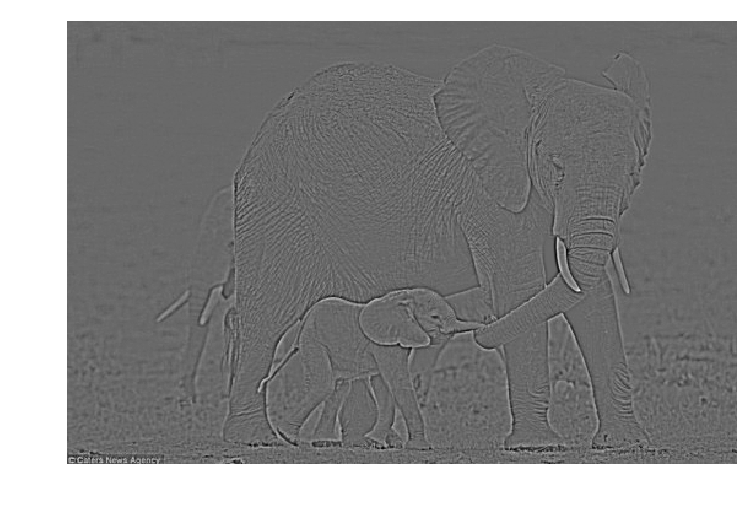

In [9]:
## 可视化卷积后的图像
plt.figure(figsize=(6,6))
plt.imshow(imconv2dout_im,cmap=plt.cm.gray)
plt.axis("off")
plt.show()

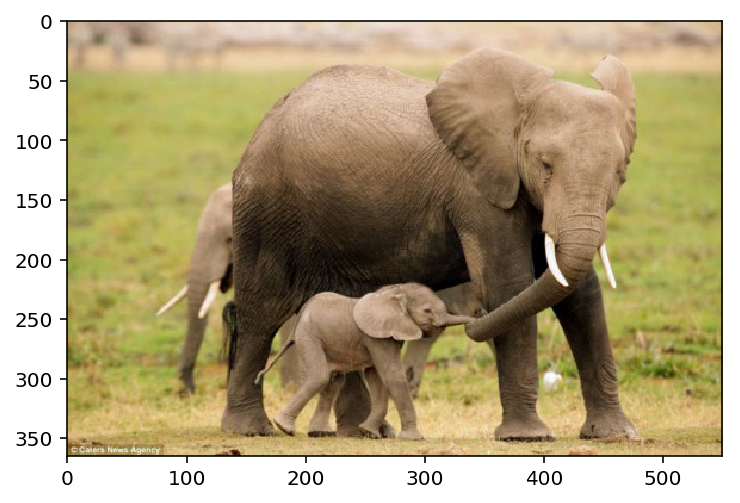

In [10]:
## 读取一张图片,并对其进行可视化
im = Image.open("data/chap6/大象.jpg")
imarray = np.asarray(im) / 255.0
plt.figure()
plt.imshow(imarray)
plt.show()

In [11]:
h,w,c = imarray.shape

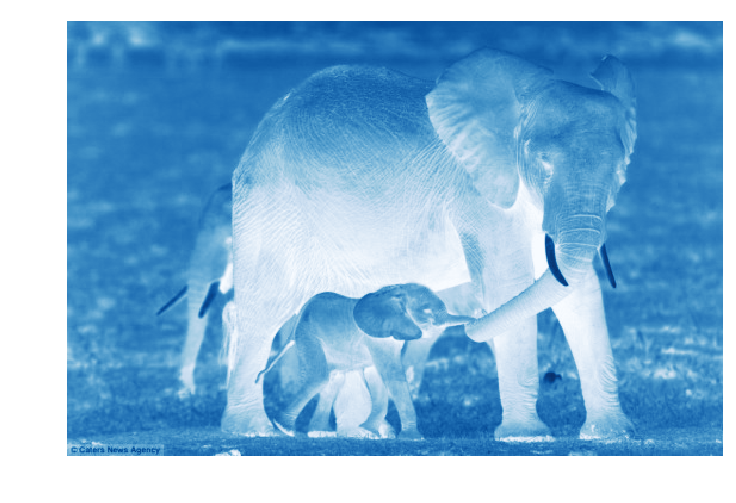

In [15]:
plt.figure()
plt.imshow(imarray[:,:,1],cmap=plt.cm.Blues)
plt.axis("off")
plt.show()

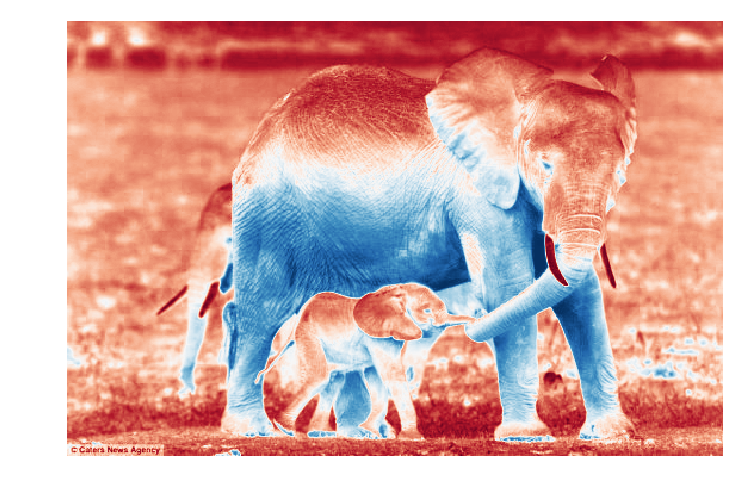

In [22]:
plt.figure()
plt.imshow(imarray[:,:,0],cmap=plt.cm.RdBu_r)
plt.axis("off")
plt.show()

In [1]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.manifold import TSNE


import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data

import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
from torchviz import make_dot

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)

In [14]:
## 设置随机数种子尽可能保证模型的结果可重复
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [23]:
## 读取数据显示数据的前几行
spam = pd.read_csv("data/chap5/spambase.csv")
## 将数据随机切分为训练集和测试集
X = spam.iloc[:,0:57].values   
y = spam.label.values
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25, random_state=123
)

## 对数据的前57列特征进行数据标准化处理
scales = MinMaxScaler(feature_range=(0, 1))
X_train_s = scales.fit_transform(X_train)
X_test_s = scales.transform(X_test)

## 将数据转化为张量
X_train_t = torch.from_numpy(X_train_s.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
X_test_t = torch.from_numpy(X_test_s.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))
## 将训练集转化为张量后,使用TensorDataset将X和Y整理到一起
train_data = Data.TensorDataset(X_train_t,y_train_t)
## 定义一个数据加载器，将训练数据集进行批量处理
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 1, # 使用两个进程 
)


In [27]:
## 全连接网络
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica,self).__init__()
        ## 定义第一个隐藏层
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features = 57, ## 第一个隐藏层的输入，数据的特征数
                out_features = 30,## 第一个隐藏层的输出，神经元的数量
                bias=True, ## 默认会有偏置
            ),
            nn.ReLU()
        )
        ## 定义第二个隐藏层
        self.hidden2 = nn.Sequential(
            nn.Linear(30,10),
            nn.ReLU()
        )
        ## 分类层
        self.classifica = nn.Sequential(
            nn.Linear(10,2),
            nn.Sigmoid()
        )

    ## 定义网络的向前传播路径   
    def forward(self, x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classifica(fc2)
        ## 输出为两个隐藏层和输出层的输出
        return fc1,fc2,output
        
## 输出我们的网络结构
mlpc = MLPclassifica()
print(mlpc)

MLPclassifica(
  (hidden1): Sequential(
    (0): Linear(in_features=57, out_features=30, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
  )
  (classifica): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


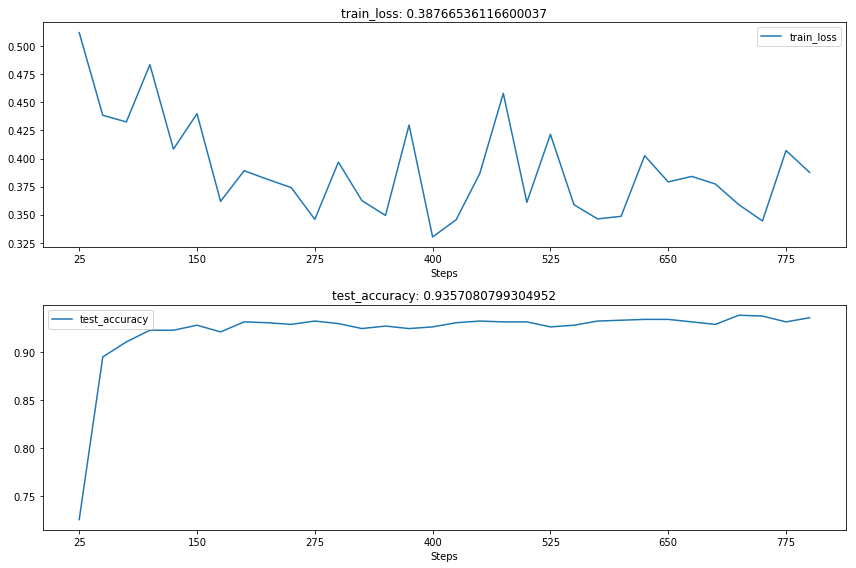

In [28]:

# 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(),lr=0.01)  
loss_func = nn.CrossEntropyLoss()   # 二分类损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(15):
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):  
        ## 计算每个batch的
        _,_,output = mlpc(b_x)               # MLP在训练batch上的输出
        train_loss = loss_func(output, b_y)   # 二分类交叉熵损失函数
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        train_loss.backward()           # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        niter = epoch*len(train_loader)+step+1
        
    ## 计算每经过print_step次迭代后的输出
        if niter % print_step == 0:
            _,_,output = mlpc(X_test_t)
            _,pre_lab = torch.max(output,1)
            test_accuracy = accuracy_score(y_test_t,pre_lab)
            # 为history添加epoch，损失和精度
            history1.log(niter, train_loss=train_loss, 
                         test_accuracy=test_accuracy)
            # 使用两个图像可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])

            

In [29]:
## 计算最终模型在测试集上的精度
_,_,output = mlpc(X_test_t)
_,pre_lab = torch.max(output,1)
test_accuracy = accuracy_score(y_test_t,pre_lab)
print("test_accuracy:",test_accuracy)
print(classification_report(y_test_t,pre_lab))
print(confusion_matrix(y_test_t,pre_lab))

test_accuracy: 0.937445699392
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       686
          1       0.92      0.93      0.92       465

avg / total       0.94      0.94      0.94      1151

[[648  38]
 [ 34 431]]


In [1]:
from scipy import stats

In [7]:
df = pd.DataFrame(data=np.random.rand(10,4))
df

,0,1,2,3
0,0.059809,0.184287,0.047355,0.674881
1,0.594625,0.533310,0.043324,0.561433
2,0.329668,0.502967,0.111894,0.607194
3,0.565945,0.006764,0.617442,0.912123
4,0.790524,0.992081,0.958802,0.791964
5,0.285251,0.624917,0.478094,0.195675
6,0.382317,0.053874,0.451648,0.982005
7,0.123943,0.119381,0.738523,0.587304
8,0.471633,0.107127,0.229219,0.899965
9,0.416754,0.535852,0.006209,0.300642


In [10]:
?df.to_json

In [3]:
torch.__version__

'1.3.1'

In [9]:
import torch
from torch_geometric.data import Data

In [13]:
import torch
from torch_geometric.data import Data


x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

edge_index = torch.tensor([[0, 2, 1, 0, 3],
                           [3, 1, 0, 1, 2]], dtype=torch.long)


data = Data(x=x, y=y, edge_index=edge_index)

In [14]:
data

Data(edge_index=[2, 5], x=[4, 2], y=[4])

In [12]:
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

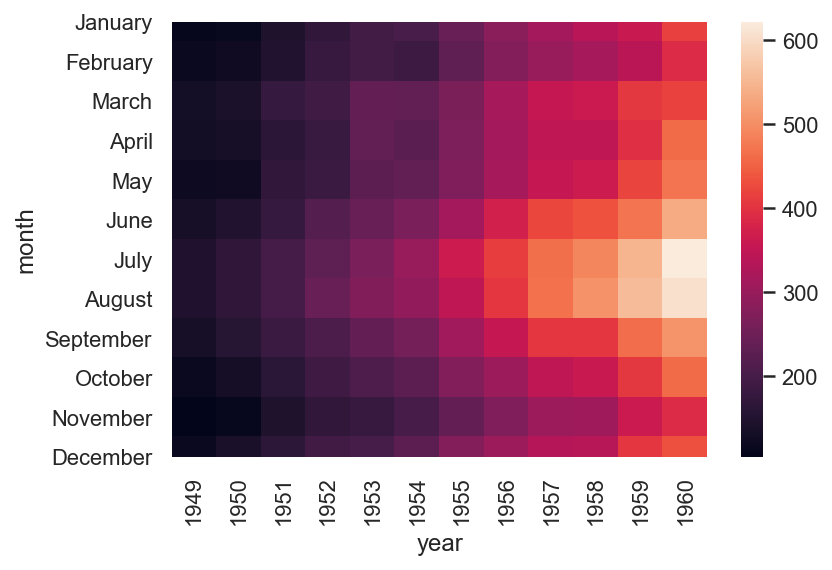

In [16]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

In [17]:
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


In [9]:
import numpy as np

In [15]:
index = ["alpha_%.2g"%ii for ii in np.arange(19)*0.01]
index

['alpha_0',
 'alpha_0.01',
 'alpha_0.02',
 'alpha_0.03',
 'alpha_0.04',
 'alpha_0.05',
 'alpha_0.06',
 'alpha_0.07',
 'alpha_0.08',
 'alpha_0.09',
 'alpha_0.1',
 'alpha_0.11',
 'alpha_0.12',
 'alpha_0.13',
 'alpha_0.14',
 'alpha_0.15',
 'alpha_0.16',
 'alpha_0.17',
 'alpha_0.18']